# Demo: Time-Varying Data

Adapted from Time-Varying Data R demo by Jordan Crouser.


In [1]:
# Set up
import pandas as pd
import numpy as np

## Just the basics
Working with time-varying data can be challenging, because unlike much of the relational data we're used to working with, observations in data that varies over time are (by definition) not independent. Luckily for us, time-varying data is also quite common, so there exist plenty of tools that can help us. 

First we'll need some time-varying data to play around with, like this one on Johnson & Johnson's quarterly earnings from 1960-1980:

In [36]:
JohnsonJohnson = pd.read_csv("JohnsonJohnson.csv")
JohnsonJohnson.dtypes

time     float64
value    float64
dtype: object

In [46]:
import datetime 

JohnsonJohnson["time"] = pd.to_datetime(JohnsonJohnson["time"])
print(JohnsonJohnson.dtypes)
JohnsonJohnson.set_index("time", inplace = True)
JohnsonJohnson.head()

time     datetime64[ns]
value           float64
dtype: object


,value
time,
1970-01-01 00:00:00.000001960,0.71
1970-01-01 00:00:00.000001960,0.63
1970-01-01 00:00:00.000001960,0.85
1970-01-01 00:00:00.000001960,0.44
1970-01-01 00:00:00.000001961,0.61


Notice how we used the `time` column as our index. 

Want just the year from a datetime?

In [53]:
JohnsonJohnson.index.year

Index([1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970,
       1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970,
       1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970,
       1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970,
       1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970,
       1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970,
       1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970],
      dtype='int32', name='time')

### Our first time series plot
Let's start with a simple plot, built for us auto-magically by `pyplot`.

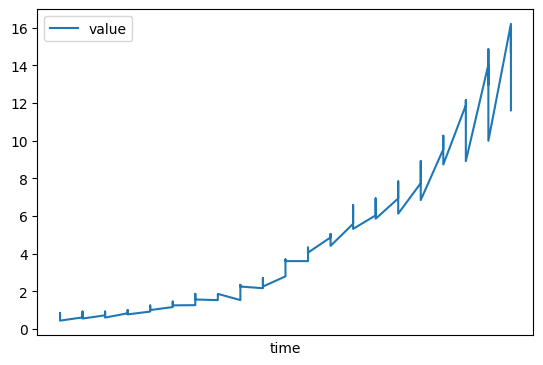

In [47]:
from matplotlib import pyplot

JohnsonJohnson.plot()
pyplot.show()

The following is based on [https://forecastegy.com/posts/change-point-detection-time-series-python/](https://forecastegy.com/posts/change-point-detection-time-series-python/). 

Nice! We can see that there's a general positive trend over time, with what appears to be little seasonal ebbs and flows and *maybe* a couple of inflection points.

Want to highlight places where the mean and variance changes? The `ruptures` library provides some useful functions (check out the link for additional methods):

(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

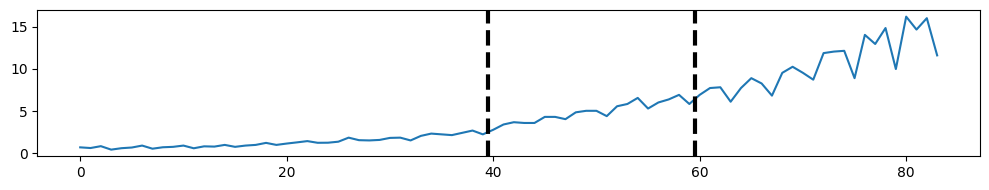

In [48]:
import ruptures as rpt

algo = rpt.Dynp(model = "l2", min_size = 20)
algo.fit(JohnsonJohnson)
result = algo.predict(n_bkps = 2)

rpt.display(JohnsonJohnson, [], result)

Want to highlight peaks? One option for this is using `plotly` and `scipy.signal`

In [57]:
import plotly.graph_objects as go
from scipy.signal import find_peaks 

time_series = JohnsonJohnson["value"]
indices = find_peaks(time_series)[0]

fig = go.Figure()
fig.add_trace(go.Scatter(
    y = time_series,
    mode = 'lines+markers',
    name = "original plot"
))

fig.add_trace(go.Scatter(
    x = indices,
    y = [time_series[j] for j in indices],
    mode = 'markers',
    marker = dict(
        size = 8,
        color = 'red',
        symbol = 'cross'
    ),
    name = 'Detected Peaks'
))

fig.show()

/var/folders/07/3zgr5b1x72d266sb132_gv400wgxz0/T/ipykernel_8322/3405665849.py:16: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



## Seasonality vs. trend

Let's check out another dataset, this time from the `astsa` package for Applied Statistical Time Series Analysis. It's a dataset of flu cases over time. 

In [59]:
flu = pd.read_csv("flu.csv")
flu.head()

,year,month,value
0,1968,1,0.811372
1,1968,2,0.445829
2,1968,3,0.341599
3,1968,4,0.277424
4,1968,5,0.248496


We can plot this like we did before with `pyplot`. But first, we need to join the year and month columns into a `datetime`. 

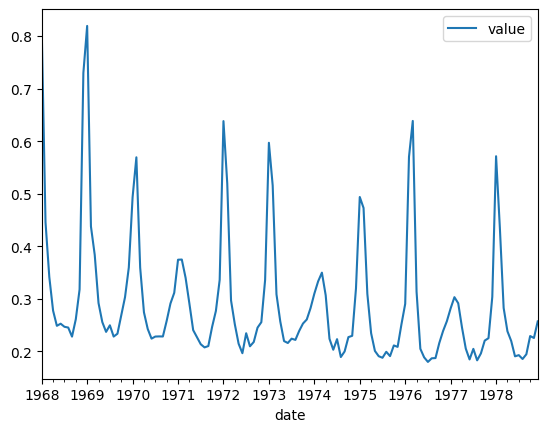

In [68]:
from matplotlib import pyplot

flu['date'] = pd.to_datetime(dict(year = flu.year, month = flu.month, day = 1))
flu.head()

flu.plot(x = 'date', y = 'value')
pyplot.show()

Whew, look at that seasonality! A seasonal time series is made up of three parts: an overall trend, a seasonal component, and niose (also known as the irregular component). If we want, we can decompose (or estimate) the time series into these three components using the `statsmodle`s library. 

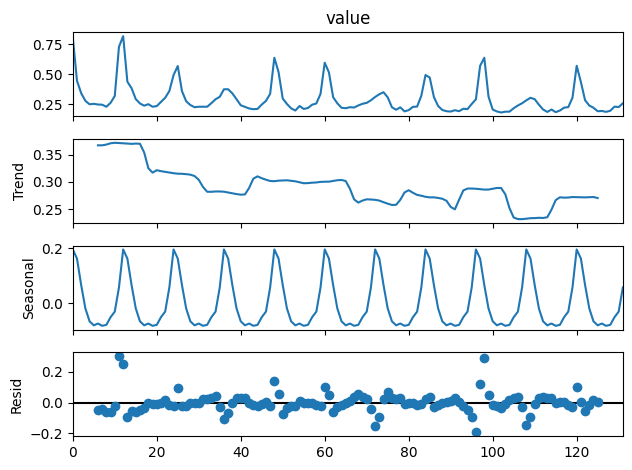

In [87]:
from statsmodels.tsa.seasonal import seasonal_decompose 

# for this to work, our data must be a series
series = pd.Series(flu['value'])

res = seasonal_decompose(series, model = 'additive', period = 12)
res.plot()
pyplot.show()

Sweet: now we can see that despite the seasonal spikes that are relatively consistent in magnitude, the overall trend is negative (that is, fewer deaths per year in the long term).

# A little more complex: NEON Harvard Forest Data
Now let's check out a slightly more interesting dataset: [meterological data](data/Met_HARV_Daily_2009_2011.csv) collected at the National Ecological Observatory Network's Harvard Forest field site. The following walkthrough is adapted from [Time Series 05: Plot Time Series with ggplot2 in R](https://www.neonscience.org/resources/learning-hub/tutorials/dc-time-series-plot-ggplot-r) by Jones et al. at NEON:

In [89]:
harMetDaily = pd.read_csv("Met_HARV_Daily_2009_2011.csv")
print(harMetDaily.dtypes)
harMetDaily.head()

Unnamed: 0      int64
date           object
jd              int64
airt          float64
f.airt         object
airtmax       float64
f.airtmax      object
airtmin       float64
f.airtmin      object
rh            float64
f.rh           object
rhmax         float64
f.rhmax        object
rhmin         float64
f.rhmin        object
dewp          float64
f.dewp         object
dewpmax       float64
f.dewpmax      object
dewpmin       float64
f.dewpmin      object
prec          float64
f.prec         object
slrt          float64
f.slrt         object
part          float64
f.part         object
netr          float64
f.netr         object
bar           float64
f.bar          object
wspd          float64
f.wspd         object
wres          float64
f.wres         object
wdir          float64
f.wdir         object
wdev          float64
f.wdev         object
gspd          float64
f.gspd         object
s10t          float64
f.s10t        float64
s10tmax       float64
f.s10tmax     float64
s10tmin   

,Unnamed: 0,date,jd,airt,f.airt,airtmax,f.airtmax,airtmin,f.airtmin,rh,...,wdev,f.wdev,gspd,f.gspd,s10t,f.s10t,s10tmax,f.s10tmax,s10tmin,f.s10tmin
0,2882,2009-01-01,1,-15.1,NaN,-9.2,NaN,-19.1,NaN,58.0,...,29.0,NaN,13.4,NaN,1.0,NaN,1.1,NaN,1.0,NaN
1,2883,2009-01-02,2,-9.1,NaN,-3.7,NaN,-15.8,NaN,75.0,...,42.0,NaN,8.1,NaN,1.0,NaN,1.0,NaN,1.0,NaN
2,2884,2009-01-03,3,-5.5,NaN,-1.6,NaN,-9.5,NaN,69.0,...,24.0,NaN,13.9,NaN,1.0,NaN,1.0,NaN,1.0,NaN
3,2885,2009-01-04,4,-6.4,NaN,0.0,NaN,-11.4,NaN,59.0,...,31.0,NaN,8.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN
4,2886,2009-01-05,5,-2.4,NaN,0.7,NaN,-6.4,NaN,77.0,...,26.0,NaN,11.6,NaN,1.0,NaN,1.1,NaN,1.0,NaN


Let's start by looking at a scatterplot of air timperature over time:

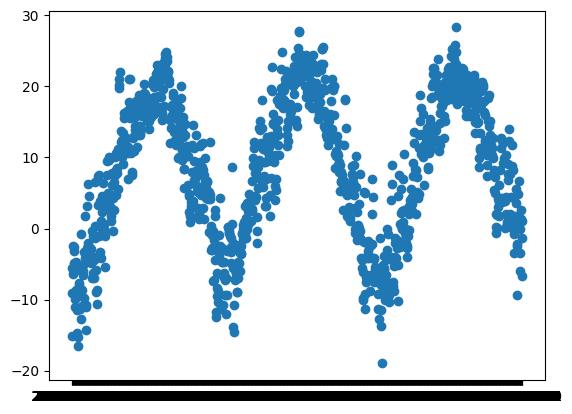

In [94]:
pyplot.plot(harMetDaily['date'], harMetDaily['airt'], 'o')
pyplot.show()

Let's fix up the x-axis: